In [1]:
%load_ext autoreload
%autoreload 2

from abc import ABC

import jax
import jax.numpy as jnp
import diffrax
import equinox as eqx
from jaxtyping import Array, Float

jax.config.update("jax_enable_x64", True)
import orc
import orc.utils.visualization as vis

## Data 

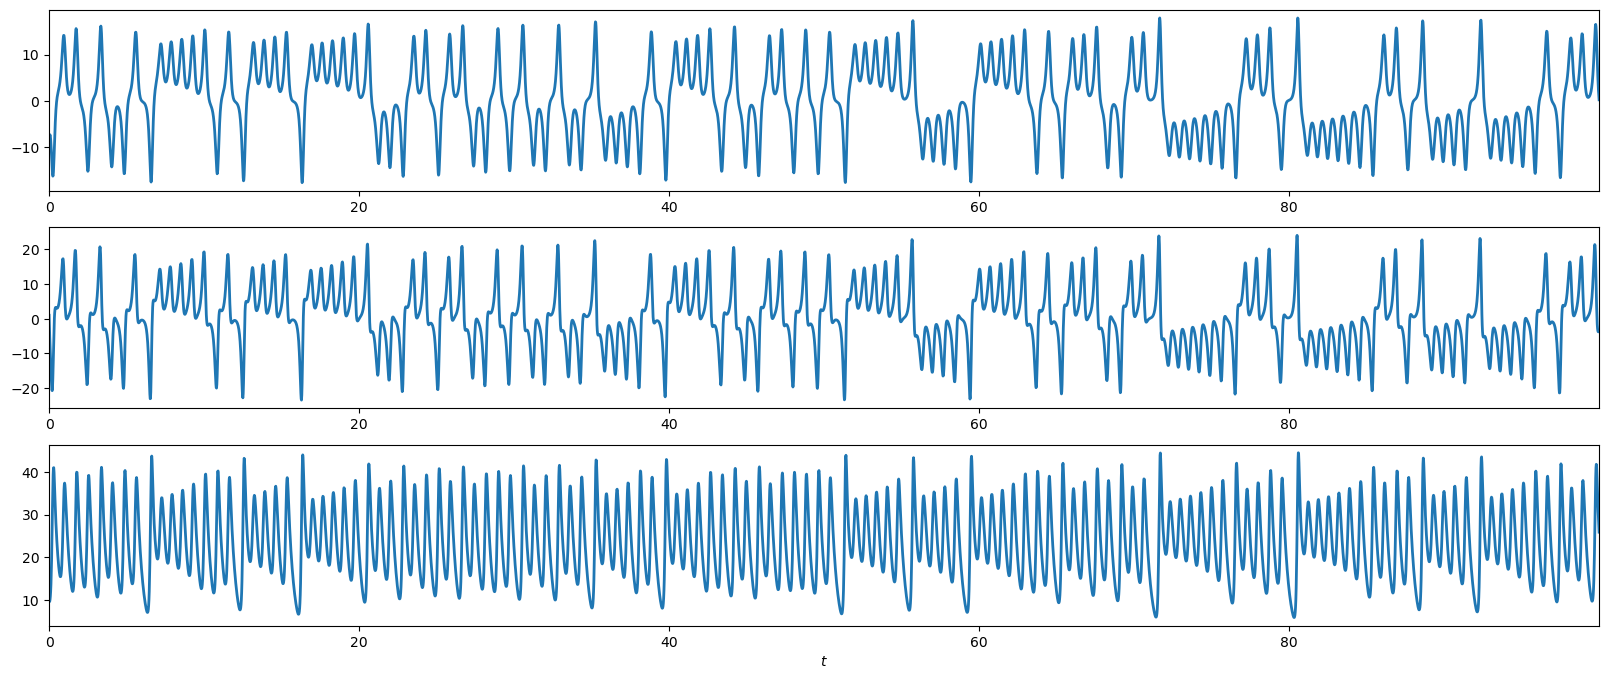

Train shape: (4000, 3), Test shape: (1000, 3)


In [2]:
tN = 100.0
dt = 0.02
test_perc = 0.2
U, t = orc.data.lorenz63(tN=tN, dt=dt)
vis.plot_time_series(U, t)

# train test split
split_idx = int((1 - test_perc) * U.shape[0])
U_train = U[:split_idx]
U_test = U[split_idx:]
t_train = t[:split_idx]
t_test = jnp.arange(U_test.shape[0]) * dt

print(f"Train shape: {U_train.shape}, Test shape: {U_test.shape}")

## Train it (Continuous)

In [3]:
esn = orc.models.CESNForecaster(data_dim=U_train.shape[1], res_dim=200, time_const=50.0)
esn, R = orc.models.train_CESNForecaster(model=esn, train_seq=U_train, t_train=t_train)

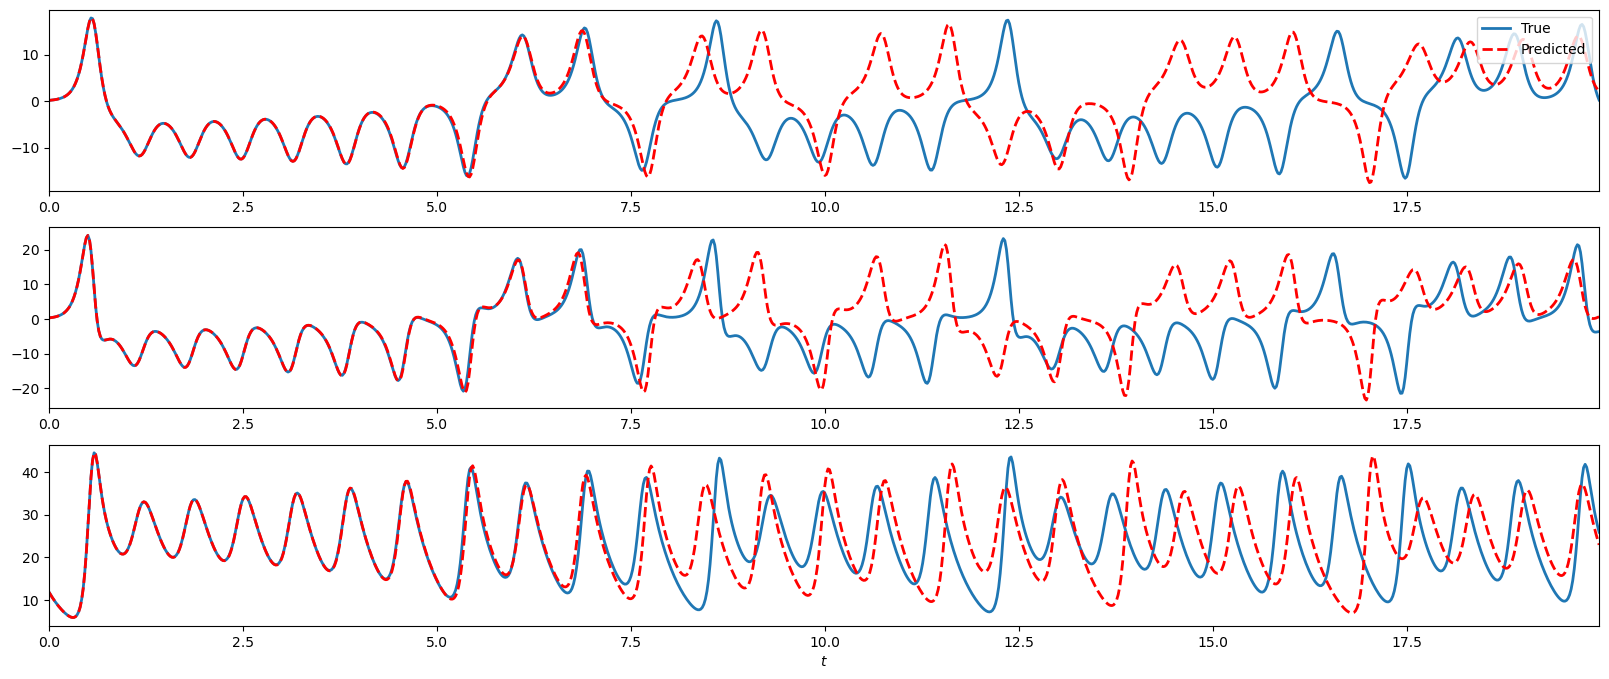

In [4]:
U_pred = esn.forecast(ts=t_test, res_state=R[-1])
vis.plot_time_series(
    [U_test, U_pred],
    t_test,
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"],
)

# Adjust RC solver / stepsize controller 

In [5]:
solver = diffrax.Euler()
stepsize_controller = diffrax.ConstantStepSize()
esn = orc.models.CESNForecaster(data_dim=U_train.shape[1], res_dim=400, time_const=50.0, solver=solver,stepsize_controller=stepsize_controller)
esn, R = orc.models.train_CESNForecaster(model=esn, train_seq=U_train, t_train=t_train)

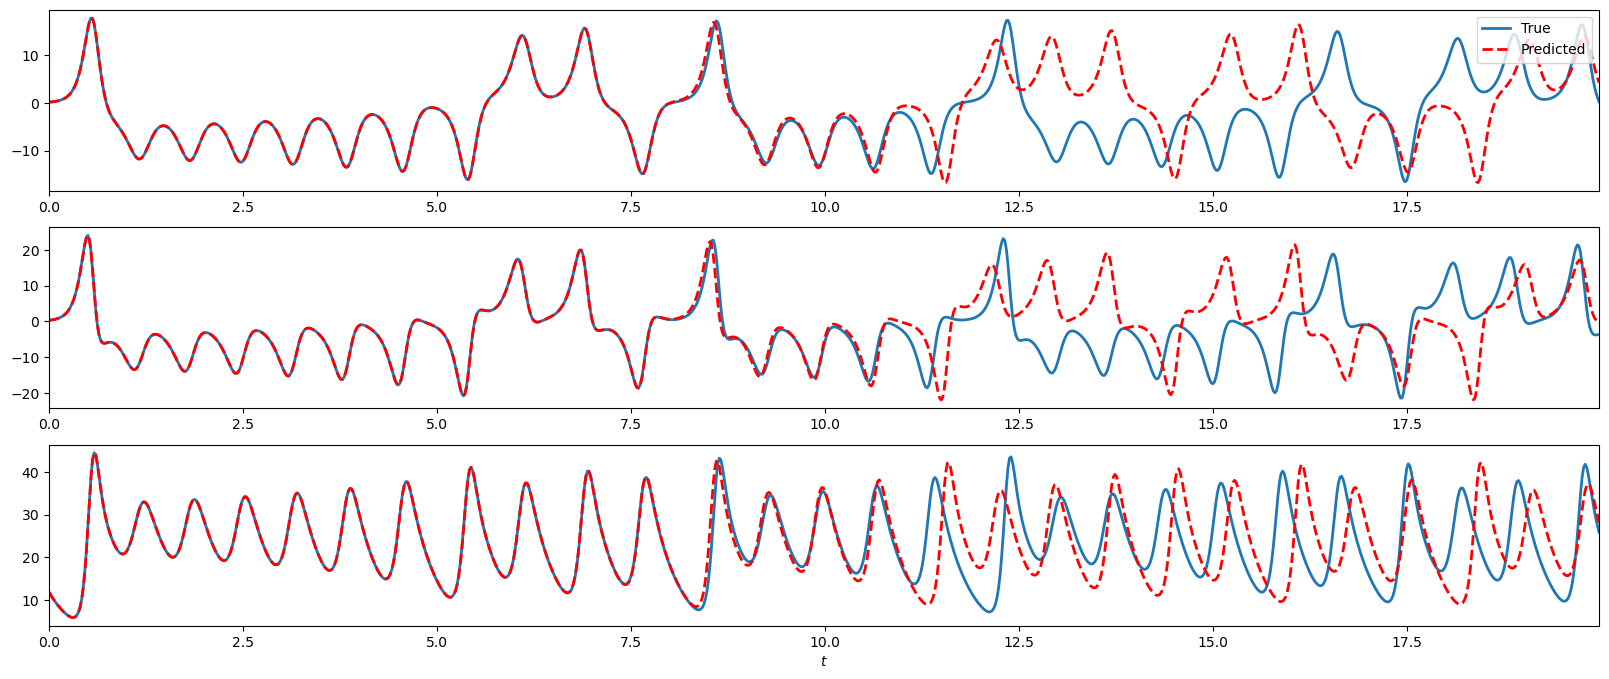

In [6]:
U_pred = esn.forecast(ts=t_test, res_state=R[-1])
vis.plot_time_series(
    [U_test, U_pred],
    t_test,
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"],
)

# Forecast from IC

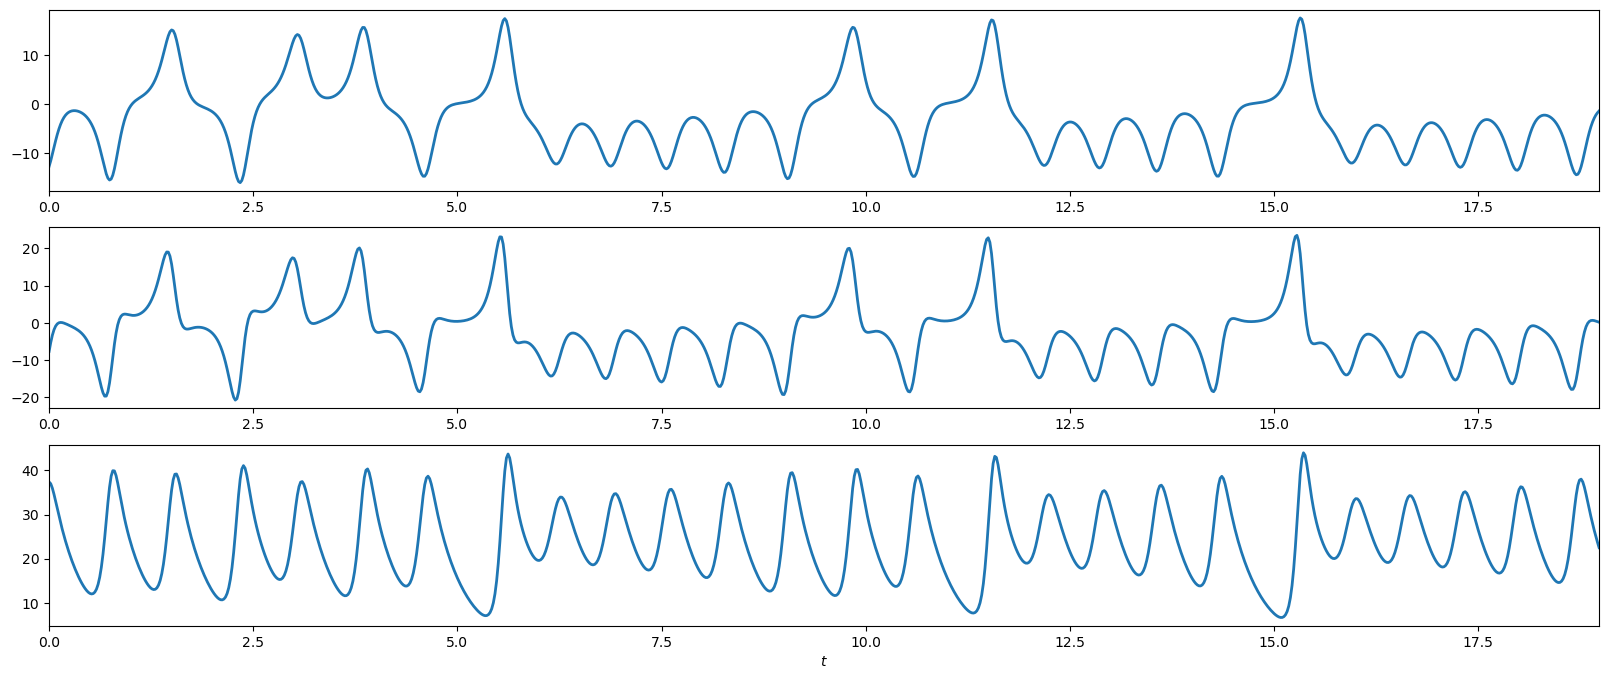

In [7]:
### Some new data 
tN = 20.0
dt = 0.02
eps = 50 # amount of spinup data

U, t = orc.data.lorenz63(tN=tN, dt=dt, u0 = [10,-1,10])
U_spinup = U[:eps]
U_test2 = U[eps:]
t_test2 = jnp.arange(U_test2.shape[0]) * dt
vis.plot_time_series(U_test2, t_test2)

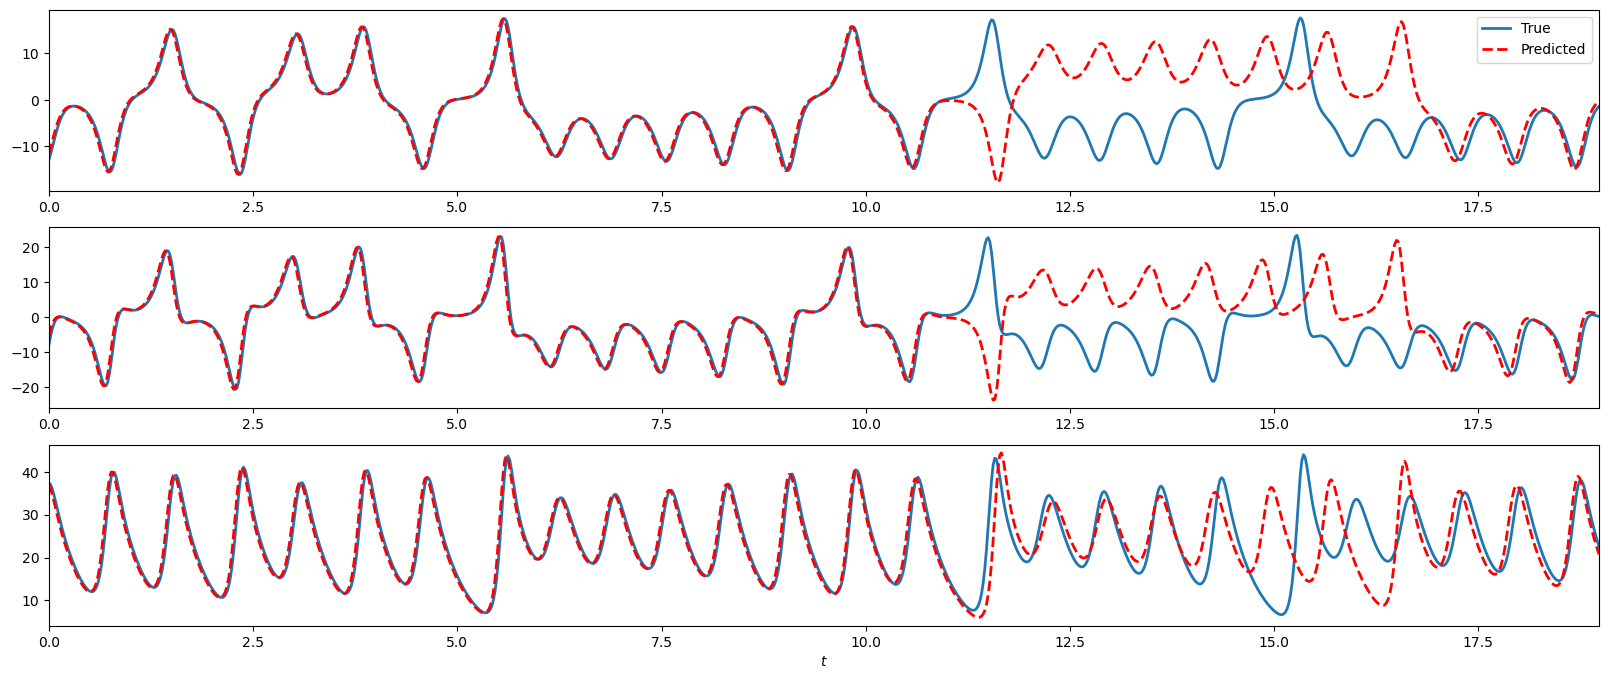

In [8]:
U_pred2 = esn.forecast_from_IC(ts=t_test2, spinup_data=U_spinup)
vis.plot_time_series(
    [U_test2, U_pred2],
    t_test2,
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"],
)